# Rakuten Image Classification - Swin Transformer

## 1. Model Definition

In [1]:
import torch
import torch.nn as nn
import timm
from typing import Optional

class RakutenSwin(nn.Module):
    """
    Swin Transformer for Rakuten product classification.
    
    ✅ Anti-Overfitting Features:
    - Stochastic Depth (drop_path_rate=0.3)
    - Robust Multi-layer Head with LayerNorm + Dropout
    """
    
    def __init__(
        self,
        model_name: str = 'swin_base_patch4_window7_224',
        num_classes: int = 27,
        pretrained: bool = True,
        drop_path_rate: float = 0.3  # ✅ Stochastic Depth
    ):
        super(RakutenSwin, self).__init__()
        
        # ✅ Load backbone with Stochastic Depth
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,  # Remove default head
            global_pool='avg',
            drop_path_rate=drop_path_rate  # ✅ KEY: Randomly drops layers
        )
        
        feature_dim = self.backbone.num_features  # 1024 for swin_base
        
        # ✅ Robust classification head (LayerNorm + Multi-layer MLP)
        self.head = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Dropout(p=0.5),
            nn.Linear(feature_dim, 512),
            nn.GELU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )
        
        self.num_classes = num_classes
        self.model_name = model_name
        self.drop_path_rate = drop_path_rate
        
        print(f"✓ RakutenSwin initialized with anti-overfitting:")
        print(f"  - Drop Path Rate: {drop_path_rate}")
        print(f"  - Head: {feature_dim} → 512 → {num_classes}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.backbone(x)
        logits = self.head(features)
        return logits

print("✅ RakutenSwin class defined (with Stochastic Depth + Robust Head)")

✅ RakutenSwin class defined (with Stochastic Depth + Robust Head)


## 2. Model Verification

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = RakutenSwin(num_classes=27, pretrained=True)
model = model.to(device)

print(f"\nModel: {model.model_name}")
print(f"Classes: {model.num_classes}")
print(f"Feature dim: {model.backbone.num_features}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

dummy_input = torch.randn(2, 3, 224, 224).to(device)
with torch.no_grad():
    output = model(dummy_input)

print(f"\nInput shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
assert output.shape == (2, 27), f"Expected shape (2, 27), got {output.shape}"
print("✓ Verification passed")

Device: cuda
✓ RakutenSwin initialized with anti-overfitting:
  - Drop Path Rate: 0.3
  - Head: 1024 → 512 → 27

Model: swin_base_patch4_window7_224
Classes: 27
Feature dim: 1024

Total parameters: 87,283,923
Trainable parameters: 87,283,923

Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 27])
✓ Verification passed


## 3. Training Setup

In [3]:
import sys
import os
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.cuda.amp import GradScaler
import wandb

project_root = Path.cwd().parent.parent
scripts_dir = project_root / "scripts"
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
if str(scripts_dir) not in sys.path:
    sys.path.insert(0, str(scripts_dir))

from src.rakuten_image.datasets import RakutenImageDataset
from load_data import split_data

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

wandb.login()

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Ti


wandb: Currently logged in as: xiaosong-dev (xiaosong-dev-formation-data-science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
CONFIG = {
    "data_dir": Path("/workspace/data"),
    "img_dir": Path("/workspace/data/images/image_train"),
    "checkpoint_dir": Path("/workspace/checkpoints/swin_mixup_v2"),  # ✅ New checkpoint dir

    "model_name": "swin_base_patch4_window7_224",
    "img_size": 224,
    "batch_size": 32,
    "num_epochs": 30,  # ✅ Increased (Mixup needs more epochs)
    "learning_rate": 5e-5,
    "weight_decay": 0.05,  # ✅ Increased from 0.1 to 0.05

    "val_split": 0.15,
    "random_state": 42,
    "early_stopping_patience": 5,
    
    # ✅ Anti-Overfitting Parameters
    "drop_path_rate": 0.3,
    "mixup_alpha": 0.8,
    "cutmix_alpha": 1.0,
    "label_smoothing": 0.1,

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_workers": 4,
    "use_amp": True,
}

print("=" * 80)
print("🛡️  ANTI-OVERFITTING CONFIGURATION")
print("=" * 80)
print(f"Device: {CONFIG['device']}")
print(f"Model: {CONFIG['model_name']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Epochs: {CONFIG['num_epochs']} (↑ for Mixup)")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Weight decay: {CONFIG['weight_decay']} (↑ regularization)")
print(f"Drop Path Rate: {CONFIG['drop_path_rate']}")
print(f"Mixup Alpha: {CONFIG['mixup_alpha']}")
print(f"CutMix Alpha: {CONFIG['cutmix_alpha']}")
print(f"Label Smoothing: {CONFIG['label_smoothing']}")
print(f"AMP: {CONFIG['use_amp']}")
print("=" * 80)

🛡️  ANTI-OVERFITTING CONFIGURATION
Device: cuda
Model: swin_base_patch4_window7_224
Batch size: 32
Epochs: 30 (↑ for Mixup)
Learning rate: 5e-05
Weight decay: 0.05 (↑ regularization)
Drop Path Rate: 0.3
Mixup Alpha: 0.8
CutMix Alpha: 1.0
Label Smoothing: 0.1
AMP: True


## 4. Data Loading

In [5]:
X_dev, X_holdout, y_dev, y_holdout = split_data()

df_dev = X_dev.copy()
df_dev['prdtypecode'] = y_dev

df_holdout = X_holdout.copy()
df_holdout['prdtypecode'] = y_holdout

print(f"Development: {len(df_dev):,} samples")
print(f"Hold-out: {len(df_holdout):,} samples")
print(f"Classes: {df_dev['prdtypecode'].nunique()}")

Development: 72,178 samples
Hold-out: 12,738 samples
Classes: 27


In [6]:
from sklearn.preprocessing import LabelEncoder

# ✅ FIX: Fit LabelEncoder ONLY on dev set (no data leakage)
label_encoder = LabelEncoder()
label_encoder.fit(df_dev['prdtypecode'])

df_dev['encoded_label'] = label_encoder.transform(df_dev['prdtypecode'])
df_holdout['encoded_label'] = label_encoder.transform(df_holdout['prdtypecode'])

num_classes = len(label_encoder.classes_)
assert num_classes == 27, f"Expected 27 classes, got {num_classes}"

print(f"✓ LabelEncoder fitted on dev set only (no data leakage)")
print(f"  Encoded classes: {num_classes}")

✓ LabelEncoder fitted on dev set only (no data leakage)
  Encoded classes: 27


In [7]:
missing_images_dev = []
for idx, row in df_dev.iterrows():
    imageid = int(row['imageid'])
    productid = int(row['productid'])
    img_path = CONFIG["img_dir"] / f"image_{imageid}_product_{productid}.jpg"
    if not img_path.exists():
        missing_images_dev.append(idx)

if missing_images_dev:
    df_dev = df_dev.drop(missing_images_dev)

missing_images_holdout = []
for idx, row in df_holdout.iterrows():
    imageid = int(row['imageid'])
    productid = int(row['productid'])
    img_path = CONFIG["img_dir"] / f"image_{imageid}_product_{productid}.jpg"
    if not img_path.exists():
        missing_images_holdout.append(idx)

if missing_images_holdout:
    df_holdout = df_holdout.drop(missing_images_holdout)

print(f"After cleaning - Dev: {len(df_dev):,}, Hold-out: {len(df_holdout):,}")

After cleaning - Dev: 72,178, Hold-out: 12,738


In [8]:
from sklearn.model_selection import train_test_split

train_indices, val_indices, _, _ = train_test_split(
    df_dev.index,
    df_dev['encoded_label'],
    test_size=0.15,
    random_state=CONFIG["random_state"],
    stratify=df_dev['encoded_label']
)

df_train = df_dev.loc[train_indices].reset_index(drop=True)
df_val = df_dev.loc[val_indices].reset_index(drop=True)
df_holdout = df_holdout.reset_index(drop=True)

print(f"Training: {len(df_train):,}")
print(f"Validation: {len(df_val):,}")
print(f"Hold-out: {len(df_holdout):,}")

Training: 61,351
Validation: 10,827
Hold-out: 12,738


In [9]:
train_transform = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = RakutenImageDataset(
    dataframe=df_train,
    image_dir=CONFIG["img_dir"],
    transform=train_transform,
    label_col="encoded_label"
)

val_dataset = RakutenImageDataset(
    dataframe=df_val,
    image_dir=CONFIG["img_dir"],
    transform=val_transform,
    label_col="encoded_label"
)

test_dataset = RakutenImageDataset(
    dataframe=df_holdout,
    image_dir=CONFIG["img_dir"],
    transform=val_transform,
    label_col="encoded_label"
)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=CONFIG["num_workers"],
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True
)

print(f"Train batches: {len(train_loader):,}")
print(f"Val batches: {len(val_loader):,}")
print(f"Test batches: {len(test_loader):,}")

Pre-loading paths into memory...
Dataset initialized with 61351 samples.
Pre-loading paths into memory...
Dataset initialized with 10827 samples.
Pre-loading paths into memory...
Dataset initialized with 12738 samples.
Train batches: 1,917
Val batches: 339
Test batches: 399


## 5. Model Initialization

In [10]:
model = RakutenSwin(
    model_name=CONFIG["model_name"],
    num_classes=num_classes,
    pretrained=True,
    drop_path_rate=CONFIG["drop_path_rate"]  # ✅ Pass drop_path_rate
)
model = model.to(CONFIG["device"])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

✓ RakutenSwin initialized with anti-overfitting:
  - Drop Path Rate: 0.3
  - Head: 1024 → 512 → 27

📊 Model Statistics:
  Total parameters: 87,283,923
  Trainable parameters: 87,283,923


In [11]:
# ============================================================================
# MIXUP & CUTMIX SETUP
# ============================================================================
from timm.data.mixup import Mixup
from timm.loss import SoftTargetCrossEntropy

# Initialize Mixup/CutMix
mixup_fn = Mixup(
    mixup_alpha=CONFIG["mixup_alpha"],
    cutmix_alpha=CONFIG["cutmix_alpha"],
    cutmix_minmax=None,
    prob=1.0,  # Apply to all batches
    switch_prob=0.5,  # 50% Mixup, 50% CutMix
    mode='batch',
    label_smoothing=CONFIG["label_smoothing"],
    num_classes=num_classes
)

# ✅ Two loss functions
criterion_train = SoftTargetCrossEntropy()  # For Mixup (soft labels)
criterion_val = nn.CrossEntropyLoss()       # For validation (hard labels)

print("✓ Mixup & CutMix initialized")
print(f"  Mixup alpha: {CONFIG['mixup_alpha']}")
print(f"  CutMix alpha: {CONFIG['cutmix_alpha']}")
print(f"  Probability: 100%")

# ============================================================================
# OPTIMIZER & SCHEDULER
# ============================================================================
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"]
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=CONFIG["num_epochs"],
    eta_min=1e-6
)

scaler = torch.amp.GradScaler('cuda') if CONFIG["use_amp"] else None

CONFIG["checkpoint_dir"].mkdir(parents=True, exist_ok=True)

with open(CONFIG["checkpoint_dir"] / "config.json", "w") as f:
    json.dump({k: str(v) for k, v in CONFIG.items()}, f, indent=2)

print("\n✓ Optimizer: AdamW with Cosine Annealing")
print(f"✓ Checkpoint dir: {CONFIG['checkpoint_dir']}")

✓ Mixup & CutMix initialized
  Mixup alpha: 0.8
  CutMix alpha: 1.0
  Probability: 100%

✓ Optimizer: AdamW with Cosine Annealing
✓ Checkpoint dir: /workspace/checkpoints/swin_mixup_v2


## 6. Training Loop

In [12]:
wandb.init(
    project="rakuten-classification",
    entity="xiaosong-dev-formation-data-science",
    config=CONFIG,
    name=f"swin_mixup_antioverfit_{pd.Timestamp.now().strftime('%m%d_%H%M')}",
    notes="Anti-overfitting: Stochastic Depth + Mixup/CutMix + Robust Head"
)

best_val_acc = 0.0
best_val_loss = float('inf')
best_val_f1 = 0.0
patience_counter = 0
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1": []
}

def update_plots():
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    axes[0].plot(history["train_loss"], label='Train Loss', marker='o', linewidth=2)
    axes[0].plot(history["val_loss"], label='Val Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history["train_acc"], label='Train Acc (not meaningful with Mixup)', marker='o', linewidth=2, linestyle='--', alpha=0.5)
    axes[1].plot(history["val_acc"], label='Val Acc', marker='s', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Best Val Acc: {best_val_acc:.2f}% | F1: {best_val_f1:.4f} (Patience: {patience_counter}/{CONFIG['early_stopping_patience']})")

print("=" * 80)
print("🚀 Starting Training with Mixup/CutMix")
print("=" * 80)

🚀 Starting Training with Mixup/CutMix


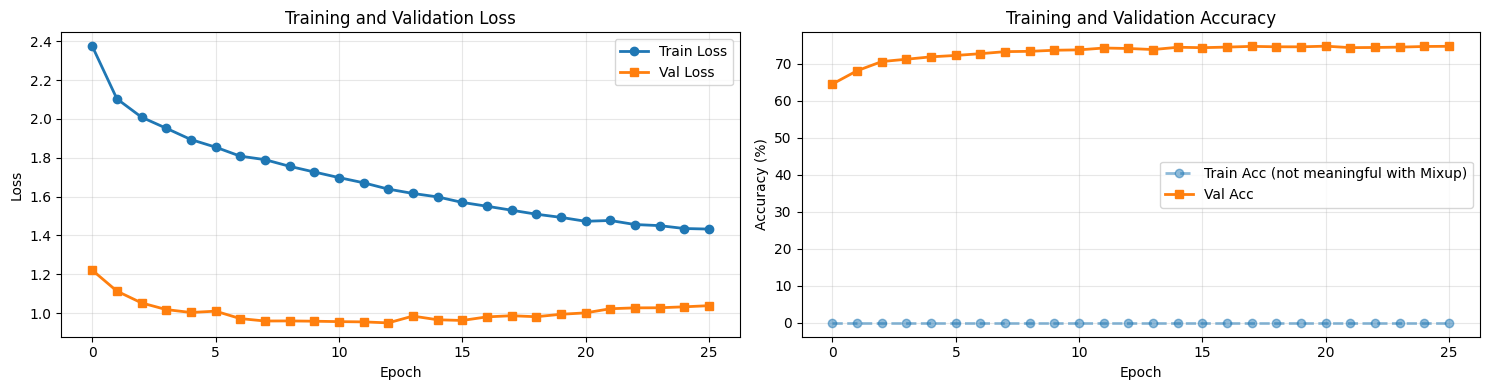

Best Val Acc: 74.77% | F1: 0.7464 (Patience: 5/5)

⚠️ Early stopping triggered after 26 epochs

🎉 Training Complete
Best Val Acc: 74.77%
Best Val F1: 0.7464


In [13]:
for epoch in range(CONFIG["num_epochs"]):
    print(f"\nEpoch {epoch + 1}/{CONFIG['num_epochs']}")
    print("=" * 80)
    
    # ========================================================================
    # TRAINING with Mixup/CutMix
    # ========================================================================
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_pbar = tqdm(train_loader, desc="Training", ncols=120)
    for images, labels in train_pbar:
        images, labels = images.to(CONFIG["device"]), labels.to(CONFIG["device"])
        
        # ✅ Apply Mixup/CutMix
        images, labels = mixup_fn(images, labels)
        
        optimizer.zero_grad()
        
        if CONFIG["use_amp"]:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(images)
                loss = criterion_train(outputs, labels)  # ✅ SoftTargetCrossEntropy
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # ✅ Gradient clipping
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion_train(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
        
        train_loss += loss.item()
        
        # Note: Accuracy not meaningful with Mixup (soft labels)
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 0.0  # Not meaningful with Mixup
    
    # ========================================================================
    # VALIDATION (no Mixup)
    # ========================================================================
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_val_preds = []
    all_val_labels = []
    
    val_pbar = tqdm(val_loader, desc="Validation", ncols=120)
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(CONFIG["device"]), labels.to(CONFIG["device"])
            
            if CONFIG["use_amp"]:
                with torch.amp.autocast(device_type="cuda"):
                    outputs = model(images)
                    loss = criterion_val(outputs, labels)  # ✅ Standard CrossEntropy
            else:
                outputs = model(images)
                loss = criterion_val(outputs, labels)
            
            val_loss += loss.item()
            predictions = torch.argmax(outputs, dim=-1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
            
            all_val_preds.extend(predictions.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * val_correct / val_total:.2f}%'
            })
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * val_correct / val_total
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    
    # ========================================================================
    # LOGGING & CHECKPOINTING
    # ========================================================================
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(0.0)  # Not meaningful
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_accuracy)
    history["val_f1"].append(val_f1)
    
    wandb.log({
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_acc": val_accuracy,
        "val_f1": val_f1,
        "epoch": epoch + 1,
        "learning_rate": optimizer.param_groups[0]['lr']
    })
    
    print(f"\n📊 Results:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | F1: {val_f1:.4f}")
    
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_val_loss = avg_val_loss
        best_val_f1 = val_f1
        patience_counter = 0
        
        checkpoint_path = CONFIG["checkpoint_dir"] / "best_model.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict() if CONFIG["use_amp"] else None,
            'val_acc': val_accuracy,
            'val_loss': avg_val_loss,
            'val_f1': val_f1,
            'train_loss': avg_train_loss,
        }, checkpoint_path)
        
        print(f"  ✅ Best model saved! (Val Acc: {val_accuracy:.2f}%, F1: {val_f1:.4f})")
    else:
        patience_counter += 1
        print(f"  ⏳ No improvement ({patience_counter}/{CONFIG['early_stopping_patience']})")
    
    scheduler.step()
    update_plots()
    
    if patience_counter >= CONFIG["early_stopping_patience"]:
        print(f"\n⚠️ Early stopping triggered after {epoch + 1} epochs")
        break

print("\n" + "=" * 80)
print("🎉 Training Complete")
print("=" * 80)
print(f"Best Val Acc: {best_val_acc:.2f}%")
print(f"Best Val F1: {best_val_f1:.4f}")
print("=" * 80)

## 7. Final Evaluation

In [14]:
checkpoint = torch.load(CONFIG["checkpoint_dir"] / "best_model.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Best model from epoch {checkpoint['epoch']}")
print(f"Val Accuracy: {checkpoint['val_acc']:.2f}%")

Best model from epoch 21
Val Accuracy: 74.77%


In [15]:
all_preds_val = []
all_labels_val = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Validation"):
        images = images.to(CONFIG["device"])
        
        if CONFIG["use_amp"]:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(images)
        else:
            outputs = model(images)
            
        predictions = torch.argmax(outputs, dim=-1)
        all_preds_val.extend(predictions.cpu().numpy())
        all_labels_val.extend(labels.numpy())

val_acc_final = accuracy_score(all_labels_val, all_preds_val)
print(f"Validation Accuracy: {val_acc_final*100:.2f}%")

Validation: 100%|██████████| 339/339 [00:26<00:00, 12.93it/s]

Validation Accuracy: 74.77%


In [16]:
all_preds_test = []
all_labels_test = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Hold-out Test"):
        images = images.to(CONFIG["device"])
        
        if CONFIG["use_amp"]:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(images)
        else:
            outputs = model(images)
            
        predictions = torch.argmax(outputs, dim=-1)
        all_preds_test.extend(predictions.cpu().numpy())
        all_labels_test.extend(labels.numpy())

test_acc_final = accuracy_score(all_labels_test, all_preds_test)
print(f"Hold-out Test Accuracy: {test_acc_final*100:.2f}%")

print("\n" + "=" * 80)
print("Classification Report (Hold-out Test)")
print("=" * 80)
print(classification_report(all_labels_test, all_preds_test, digits=4, zero_division=0))

Hold-out Test: 100%|██████████| 399/399 [00:30<00:00, 12.94it/s]

Hold-out Test Accuracy: 74.64%

Classification Report (Hold-out Test)
              precision    recall  f1-score   support

           0     0.6740    0.7880    0.7266       467
           1     0.7044    0.7287    0.7163       376
           2     0.6051    0.6627    0.6326       252
           3     0.7769    0.7520    0.7642       125
           4     0.7129    0.7182    0.7155       401
           5     0.9441    0.9680    0.9559       593
           6     0.5526    0.5478    0.5502       115
           7     0.5286    0.4555    0.4893       731
           8     0.4536    0.4084    0.4298       311
           9     0.7790    0.8520    0.8139       757
          10     0.7955    0.8678    0.8300       121
          11     0.6023    0.5668    0.5840       374
          12     0.6235    0.6337    0.6286       486
          13     0.6554    0.6373    0.6462       761
          14     0.8658    0.8591    0.8625       646
          15     0.7967    0.8167    0.8066       120
          1

In [17]:
history_path = CONFIG["checkpoint_dir"] / "training_history.json"
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)

results = {
    "best_epoch": int(checkpoint['epoch']),
    "val_acc": float(checkpoint['val_acc']),
    "final_val_acc": float(val_acc_final * 100),
    "final_test_acc": float(test_acc_final * 100),
    "num_classes": int(num_classes),
    "model": CONFIG["model_name"]
}

results_path = CONFIG["checkpoint_dir"] / "final_results.json"
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"History saved: {history_path}")
print(f"Results saved: {results_path}")

History saved: /workspace/checkpoints/swin_mixup_v2/training_history.json
Results saved: /workspace/checkpoints/swin_mixup_v2/final_results.json


## 8. Visualizations

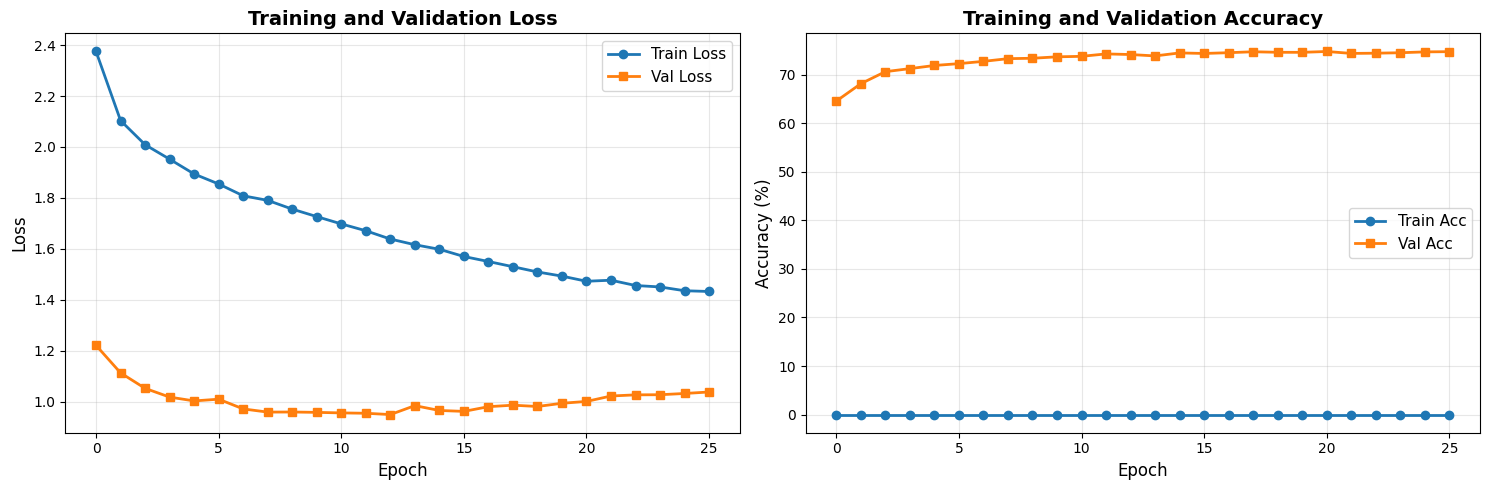

Plot saved: /workspace/checkpoints/swin_mixup_v2/training_curves.png


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history["train_loss"], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history["val_loss"], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history["train_acc"], label='Train Acc', marker='o', linewidth=2)
axes[1].plot(history["val_acc"], label='Val Acc', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = CONFIG["checkpoint_dir"] / 'training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot saved: {plot_path}")

## 9. Summary

In [19]:
print("=" * 80)
print("Training Summary")
print("=" * 80)
print(f"Model: {CONFIG['model_name']}")
print(f"Total samples: {len(df_train) + len(df_val) + len(df_holdout):,}")
print(f"Training: {len(train_dataset):,}")
print(f"Validation: {len(val_dataset):,}")
print(f"Hold-out: {len(test_dataset):,}")
print(f"Classes: {num_classes}")
print(f"\nBest epoch: {checkpoint['epoch']}")
print(f"Best val accuracy: {checkpoint['val_acc']:.2f}%")
print(f"Final val accuracy: {val_acc_final*100:.2f}%")
print(f"Final test accuracy: {test_acc_final*100:.2f}%")
print("=" * 80)

wandb.finish()

Training Summary
Model: swin_base_patch4_window7_224
Total samples: 84,916
Training: 61,351
Validation: 10,827
Hold-out: 12,738
Classes: 27

Best epoch: 21
Best val accuracy: 74.77%
Final val accuracy: 74.77%
Final test accuracy: 74.64%


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▃▅▆▆▆▇▇▇▇▇██▇████████████
val_f1,▁▃▅▆▆▆▇▇▇▇▇▇█▇████████████
val_loss,█▅▄▃▂▃▂▁▁▁▁▁▁▂▁▁▂▂▂▂▂▃▃▃▃▃
epoch,26
learning_rate,0.0
train_loss,1.43292
val_acc,74.72984
val_f1,0.74579
